In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import rotate, resize, pad, crop, hflip, vflip
import random
import matplotlib.pyplot as plt

For now, please do not run on any other dataset than dSprites!!!

In [2]:
BATCH_SIZE = 5

In [3]:
"""
Augmentations implementation, mostly designed for/inspired by dSprites

Parameters
----------
image: a PyTorch tensor defined by (# channels, height, width) shape
"""

# 1. rotation
def random_rotation(image):
    return rotate(image, random.randrange(0, 360))

# 2. scaling

# for any general image dataset, but note it might be good to consider specifics, like I did for dSprites
def shrink_and_pad(image):
    scale_factor = random.uniform(0.5, 0.9)  # Adjust the range according to your needs
    new_width = int(image.shape[2] * scale_factor)
    new_height = int(image.shape[1] * scale_factor)
    resized_image = resize(image, (new_height, new_width))

    # Calculate padding values to maintain the original dimensions
    pad_left_amt = (image.shape[2] - new_width) // 2
    pad_top_amt = (image.shape[1] - new_height) // 2
    pad_right_amt = image.shape[2] - new_width - pad_left_amt
    pad_bottom_amt = image.shape[1] - new_height - pad_top_amt

    # Pad the resized image with black pixels
    # default fill value is 0
    padded_image = pad(resized_image, (pad_left_amt, pad_top_amt, pad_right_amt, pad_bottom_amt))

    return padded_image

# for dSprites, we want to preserve position while scaling the shape

def get_shape_bounds(image):
    """helper method to obtain bounding box of shape sprite"""
    white_pixels = image.nonzero(as_tuple=True)
    y_min, y_max = white_pixels[1].min(), white_pixels[1].max()
    x_min, x_max = white_pixels[2].min(), white_pixels[2].max()
    return x_min, x_max, y_min, y_max

def shrink_shape_and_pad(image):
    """shrinks a shape sprite while maintaining position
    and returns the corresponding image with the same dimensions as `image`"""
    ## Calculations
    x1, x2, y1, y2 = get_shape_bounds(image)
    # bounding box dimensions of sprite/shape
    shape_width, shape_height = x2 - x1 + 1, y2 - y1 + 1

    # scale_factor = random.uniform(0.6, 1.2) <-- cannot do larger than 1.0 since I'm working with a bounding box
    scale_factor = random.uniform(0.6, 0.9)
    # print("Scale factor: " + str(scale_factor))
    while scale_factor == 1.0:
        scale_factor = random.uniform(0.6, 0.9)

    new_width, new_height = int(shape_width * scale_factor), int(shape_height * scale_factor)

    # compute padding amounts in 4 directions
    left_pad_amt = (shape_width - new_width) // 2
    top_pad_amt = (shape_height - new_height) // 2
    right_pad_amt = shape_width - left_pad_amt - new_width
    bottom_pad_amt = shape_height - top_pad_amt - new_height 


    ## Applying our calculations 
    # crop out and resize the shape sprite itself
    rescaled_shape = resize(crop(image, left=x1, top=y1, width=shape_width, height=shape_height), (new_height, new_width))

    # applying padding to preserve center spot of shape
    padded_rescaled_shape = pad(rescaled_shape, (left_pad_amt, top_pad_amt, right_pad_amt, bottom_pad_amt))

    to_ret = torch.clone(image)

    to_ret[0, y1:y2+1, x1:x2+1] = padded_rescaled_shape
    return to_ret



# 3. Translation - dSprite-specific augmentation
def get_max_shift_amts(image):
    x_min, x_max, y_min, y_max = get_shape_bounds(image)
    max_shift_left = x_min
    max_shift_right = image.size(2) - x_max
    max_shift_up = y_min
    max_shift_down = image.size(1) - y_max
    return max_shift_left, max_shift_right, max_shift_up, max_shift_down


def translate_shape(image):
    """translates a shape sprite by a random, in-bound amount in the x and y directions
    and returns the corresponding image with the same dimensions as `image`"""
    ## Calculations
    x1, x2, y1, y2 = get_shape_bounds(image)
    msl, msr, msu, msd = get_max_shift_amts(image)

    # to avoid choosing 0 as a potential shift value
    shift_x = np.random.choice(np.append(np.arange(-msl, 0), np.arange(1, msr)))
    shift_y = np.random.choice(np.append(np.arange(-msu, 0), np.arange(1, msd)))

    ## Applying calculations 
    to_ret = torch.clone(image)

    # get shape, clear out original spot, and place shape in translated spot

    # this way, the 0 assignment afterwards doesn't affect shape_bbox too to become all 0s
    shape_bbox = torch.clone(to_ret[0, y1:y2+1, x1:x2+1])

    to_ret[0, y1:y2+1, x1:x2+1] = 0
    to_ret[0 , y1+shift_y : y2+1+shift_y , x1+shift_x : x2+1+shift_x] = shape_bbox

    return to_ret


# 4. Flipping (horizontal/vertical) is built-into PyTorch

DSPRITE_AUGMENTATIONS = [random_rotation, shrink_shape_and_pad, translate_shape, hflip, vflip]
# TODO: AUGMENTATIONS = []
AUGMENTATIONS = [random_rotation, shrink_and_pad, hflip, vflip]

In [4]:
def convert_to_tripletBatch(batch):
    """"
    Translates Joseph Lee's honors thesis idea with data augmentation --> dataloader implementation 

    Proccesses a batch of data sequentially (in the form) of a list
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    # get image dimensions, assuming all images are the same size
    # and it is number-of-channels (nc) first
    nc, h, w = batch[0].shape[-3], batch[0].shape[-2], batch[0].shape[-1]
    batch_size = len(batch)

    """to return batches of 3 (original image, augmented original, and another image)
    implies we need at least two separate images to work off of""" 
    if batch_size >= 2:
        print(f"Batch size: {batch_size}")
        # format: (batch_size, 3 for (original, augmented, another), num_channels, height, width)
        images_batch = torch.zeros((batch_size, 3, nc, h, w))
        
        for i in range(batch_size - 1):         
            first_image_index = i
            second_image_index = i + 1 # can be i and i + 1 if we toggle shuffle = True, so that it's random
            first_image = batch[first_image_index]
            second_image = batch[second_image_index]
            first_image_augmented = random.choice(AUGMENTATIONS)(first_image)

            images_batch[i, 0, :, :, :] = first_image
            images_batch[i, 1, :, :, :] = first_image_augmented
            images_batch[i, 2, :, :, :] = second_image
        
        # the "second_image" here is the starting image of the batch
        # This is to address the out of bounds error
        images_batch[batch_size-1, 0, :, :, :] = batch[batch_size-1]
        images_batch[batch_size-1, 1, :, :, :] = random.choice(AUGMENTATIONS)(batch[batch_size-1])
        images_batch[batch_size-1, 2, :, :, :] = batch[0] 


    # otherwise, just create an (original image, augmented original) pair
    else:
        assert batch_size == 1
        images_batch = torch.zeros((batch_size, 2, nc, h, w))
        images_batch[0, 0, :, :, :] = batch[0]
        images_batch[0, 1, :, :, :] = rotate(batch[0], random.randrange(0, 360))
        
    return images_batch


def convert_to_tripletBatch_debug(batch):
    """"
    Proccesses a PyTorch-default batch of data sequentially, which (in the form) of a list,
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of tensors representing images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    print("Here is the batch in `collate_fn`")
    print(batch)
    print("List of Tensor sizes in batch:")
    print([tensor.shape for tensor in batch])

    return convert_to_tripletBatch(batch)

In [5]:
def show_triplets_in_batch(dataloader: DataLoader):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(BATCH_SIZE, 3, figsize=(15, 15))

    batch = next(iter(dataloader))
    titles = ['Image 1', 'Augmented 1', 'Image 2']

    for batch_idx, triplet in enumerate(batch):
        for triplet_idx, image in enumerate(triplet):
            axs[batch_idx, triplet_idx].imshow(torch.permute(image, (1, 2, 0)))
            axs[batch_idx, triplet_idx].set_title(titles[triplet_idx])

    fig.suptitle(f'Batch of {BATCH_SIZE} Triplets')

    plt.show()


In [6]:
class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index]

In [7]:
(1, *[3, 4])

(1, 3, 4)

# Toy Data Experimentation

In [8]:
# images = torch.randn(5, 1, 3, 3)
# dataset = ImageDataset(images)
# dataloader = DataLoader(dataset, batch_size=2, collate_fn=convert_to_tripletBatch_debug, shuffle=True)

# for batch in dataloader:
#     batch = batch.view(batch.shape[0]*batch.shape[1], *batch.shape[2:]) 
#     print(f"Batch output with shape {batch.shape}")
#     print(batch)
#     print("\n\n")

In [9]:
# images.shape

# CelebA

In [10]:
from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform)

    def __getitem__(self, index):
        path = self.imgs[index][0]
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img


In [11]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])

train_kwargs = {'root': "./data/CelebA", 'transform': transform}
celeba_data = CustomImageFolder(**train_kwargs)

In [12]:
len(celeba_data)

202599

In [13]:
celeba_dataloader = DataLoader(celeba_data, batch_size=BATCH_SIZE, 
                               collate_fn=convert_to_tripletBatch, shuffle=True)

Batch size: 5


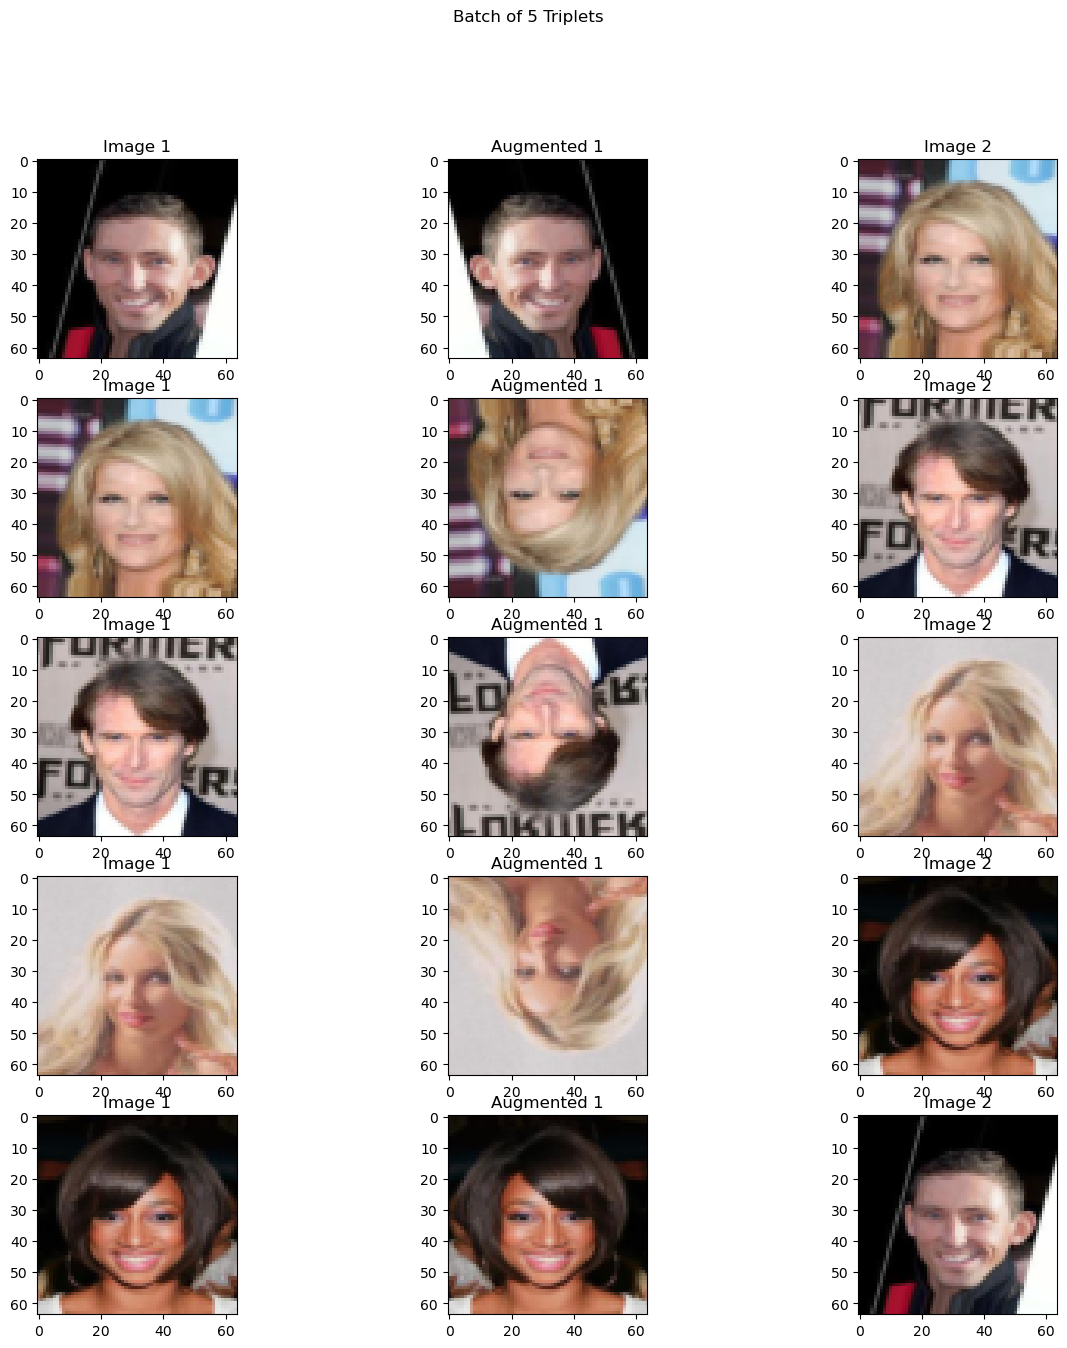

In [14]:
show_triplets_in_batch(celeba_dataloader)

# 3DChairs

In [15]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])

train_kwargs = {'root': "./data/3DChairs", 'transform': transform}
chairs3D_data = CustomImageFolder(**train_kwargs)

In [16]:
chairs3D_dataloader = DataLoader(chairs3D_data, batch_size=BATCH_SIZE, 
                                 collate_fn=convert_to_tripletBatch, shuffle=True)

Batch size: 5


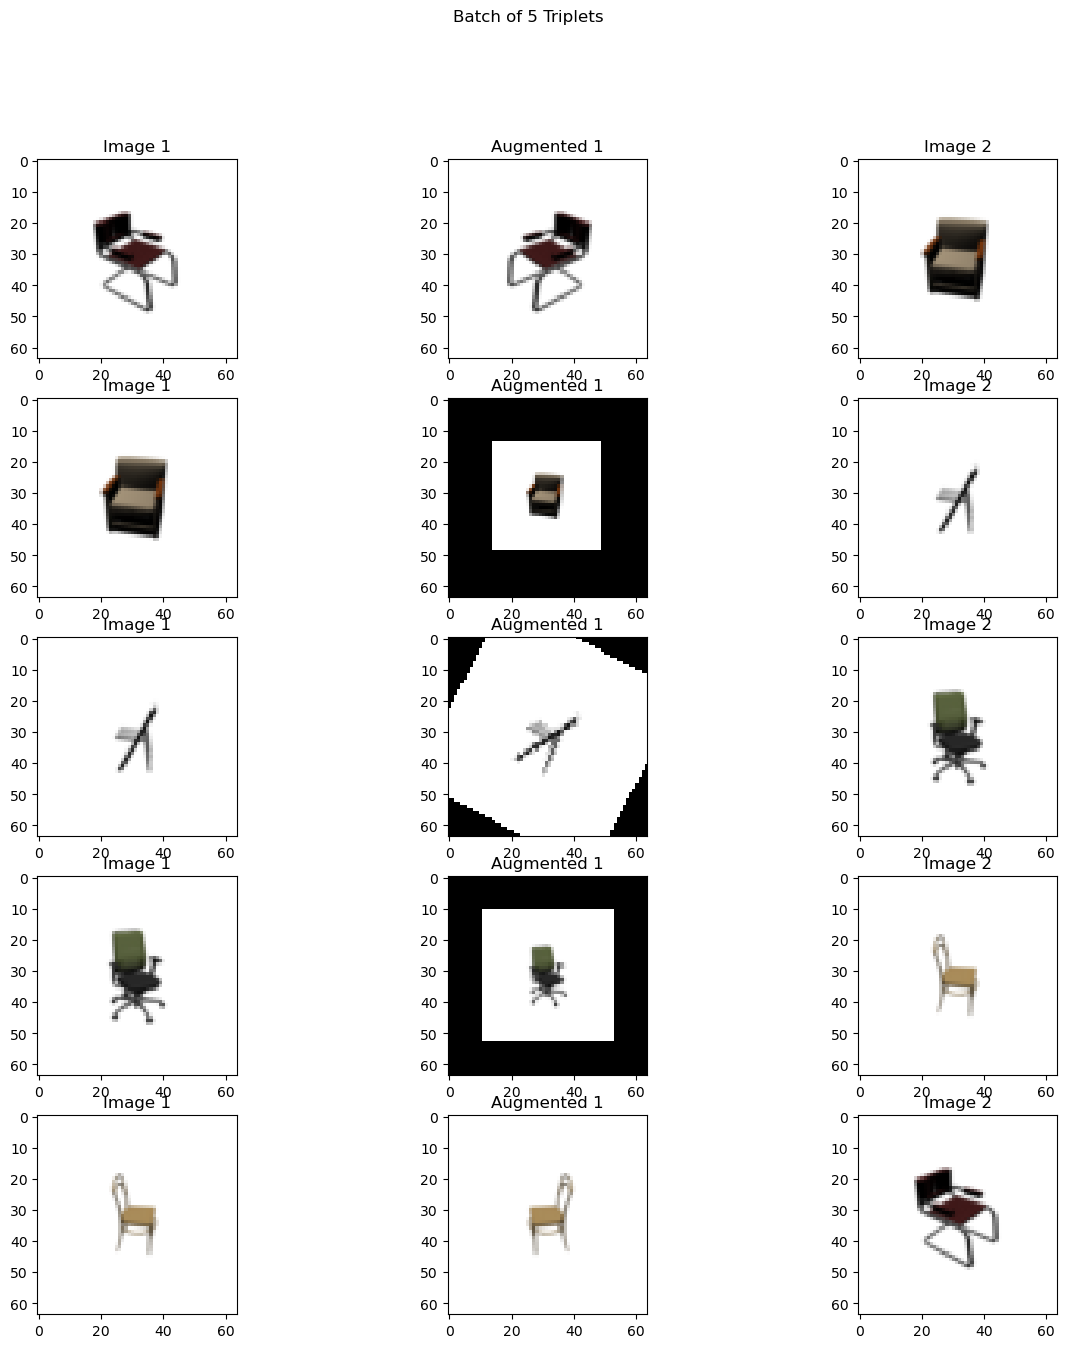

In [17]:
show_triplets_in_batch(chairs3D_dataloader)

# dSprites

In [18]:
class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor):
        self.data_tensor = data_tensor

    def __getitem__(self, index):
        return self.data_tensor[index]

    def __len__(self):
        return self.data_tensor.size(0)


In [19]:
def triplet_batch_dSprites(batch):
    """"
    Translates Joseph Lee's honors thesis idea with data augmentation --> dataloader implementation 

    Proccesses a batch of data sequentially (in the form) of a list
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    # get image dimensions, assuming all images are the same size
    # and it is number-of-channels (nc) first
    nc, h, w = batch[0].shape[-3], batch[0].shape[-2], batch[0].shape[-1]
    batch_size = len(batch)

    """to return batches of 3 (original image, augmented original, and another image)
    implies we need at least two separate images to work off of""" 
    if batch_size >= 2:
        print(f"Batch size: {batch_size}")
        # format: (batch_size, 3 for (original, augmented, another), num_channels, height, width)
        images_batch = torch.zeros((batch_size, 3, nc, h, w))
        
        for i in range(batch_size - 1):         
            first_image_index = i
            second_image_index = i + 1 # can be i and i + 1 if we toggle shuffle = True, so that it's random
            first_image = batch[first_image_index]
            second_image = batch[second_image_index]
            first_image_augmented = random.choice(DSPRITE_AUGMENTATIONS)(first_image)

            images_batch[i, 0, :, :, :] = first_image
            images_batch[i, 1, :, :, :] = first_image_augmented
            images_batch[i, 2, :, :, :] = second_image
        
        # the "second_image" here is the starting image of the batch
        # This is to address the out of bounds error
        images_batch[batch_size-1, 0, :, :, :] = batch[batch_size-1]
        images_batch[batch_size-1, 1, :, :, :] = random.choice(DSPRITE_AUGMENTATIONS)(batch[batch_size-1])
        images_batch[batch_size-1, 2, :, :, :] = batch[0] 


    # otherwise, just create an (original image, augmented original) pair
    else:
        assert batch_size == 1
        images_batch = torch.zeros((batch_size, 2, nc, h, w))
        images_batch[0, 0, :, :, :] = batch[0]
        images_batch[0, 1, :, :, :] = rotate(batch[0], random.randrange(0, 360))
        
    return images_batch



In [20]:
import numpy as np
dSprites_data = np.load("./data/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz", encoding='bytes')
dSprites_data = torch.from_numpy(dSprites_data['imgs']).unsqueeze(1).float()

In [21]:
dSprites_dataset = CustomTensorDataset(data_tensor = dSprites_data)
dSprites_dataloader = DataLoader(dSprites_dataset, batch_size=BATCH_SIZE, 
                                 collate_fn=triplet_batch_dSprites, shuffle=True)

Batch size: 5


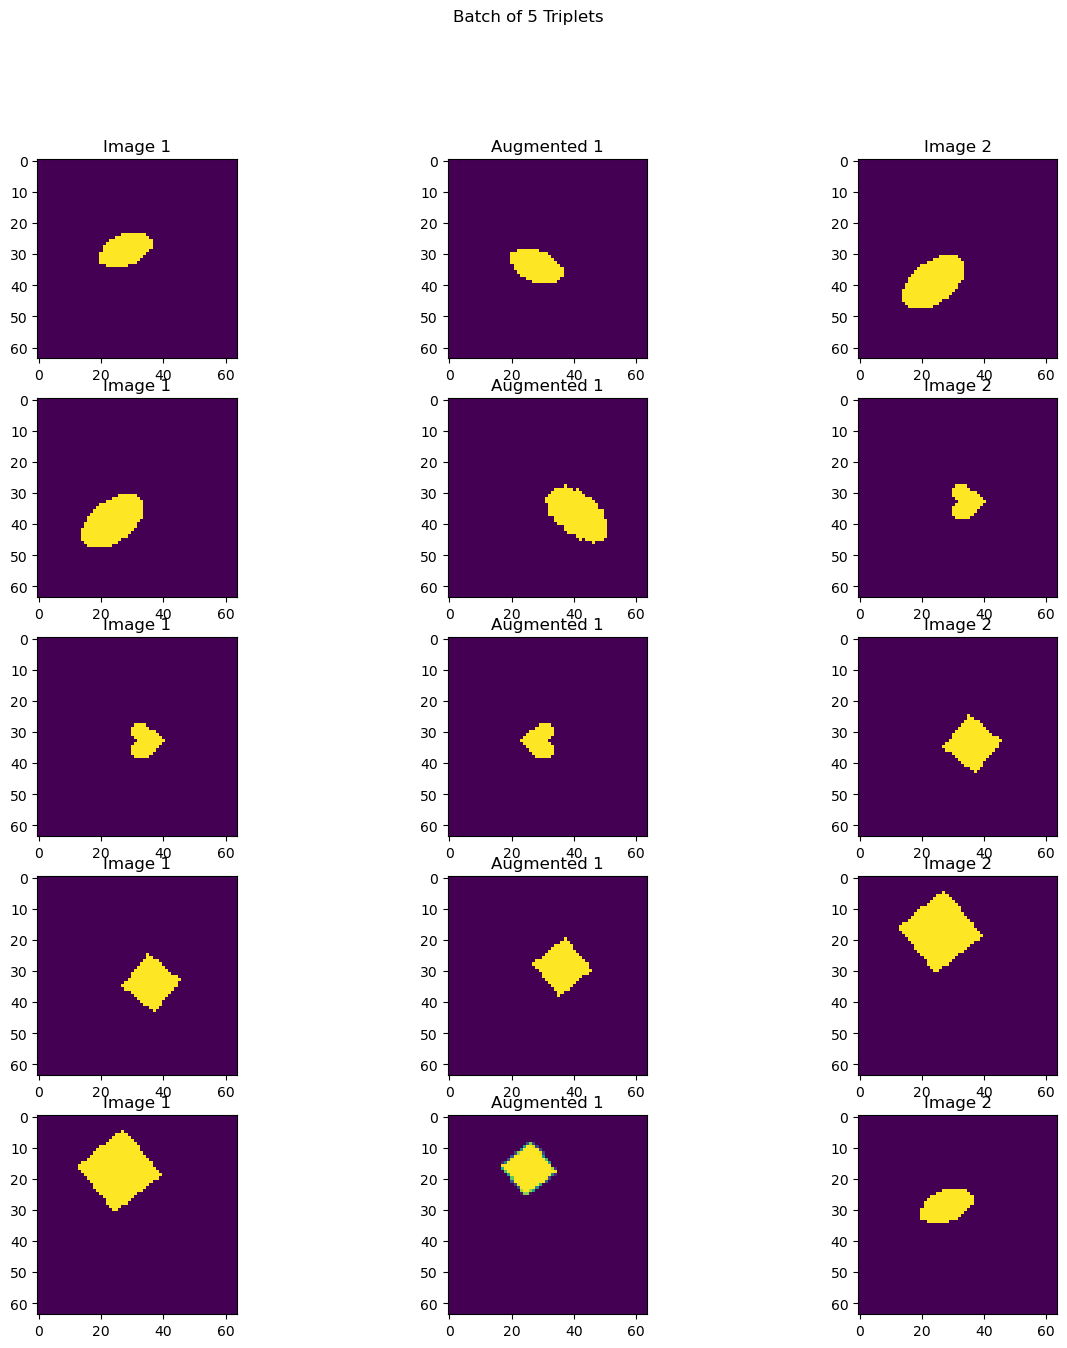

In [22]:
show_triplets_in_batch(dSprites_dataloader)

## Testing Out `dSprites` Augmentations at an Individual Sample Level

In [23]:
sample_ds_img = random.choice(dSprites_data)
# shape_locs_tup = sample_ds_img.nonzero(as_tuple=True)
# shape_locs_tup
shape_bounds = get_shape_bounds(sample_ds_img)
shape_bounds

(tensor(23), tensor(31), tensor(18), tensor(27))

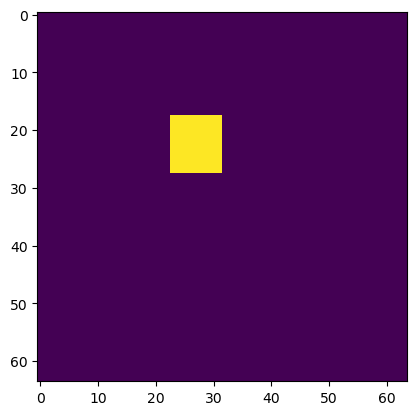

In [24]:
import matplotlib.pyplot as plt
plt.imshow(sample_ds_img.permute(1, 2, 0))

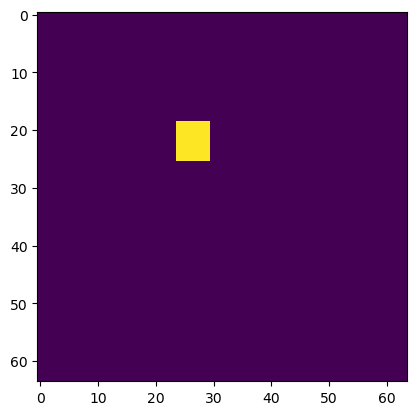

In [26]:
plt.imshow(shrink_shape_and_pad(sample_ds_img).permute(1, 2, 0))

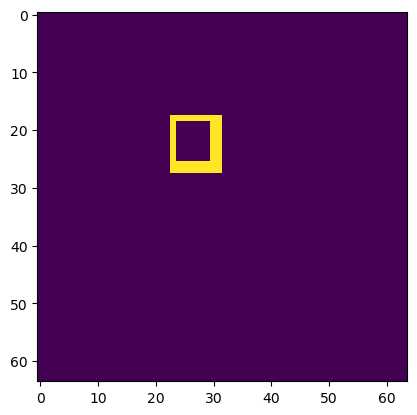

In [27]:
plt.imshow(sample_ds_img.permute(1,2,0) - shrink_shape_and_pad(sample_ds_img).permute(1, 2, 0))

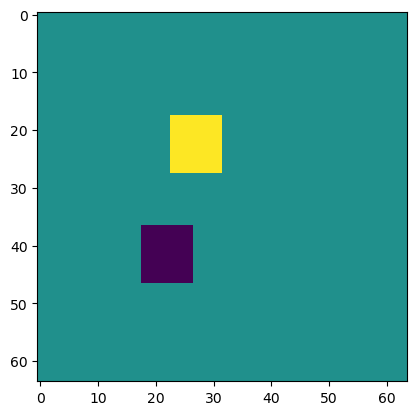

In [28]:
plt.imshow(sample_ds_img.permute(1,2,0) - translate_shape(sample_ds_img).permute(1, 2, 0))